In [33]:
from ML_preprocessing import prepare_data_for_ML
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    FunctionTransformer,
    QuantileTransformer,
    quantile_transform,
)
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


X_train, X_test, y_train, y_test = prepare_data_for_ML("BTC/USDT", day_to_forecast=1)

# Distributins after transformation 


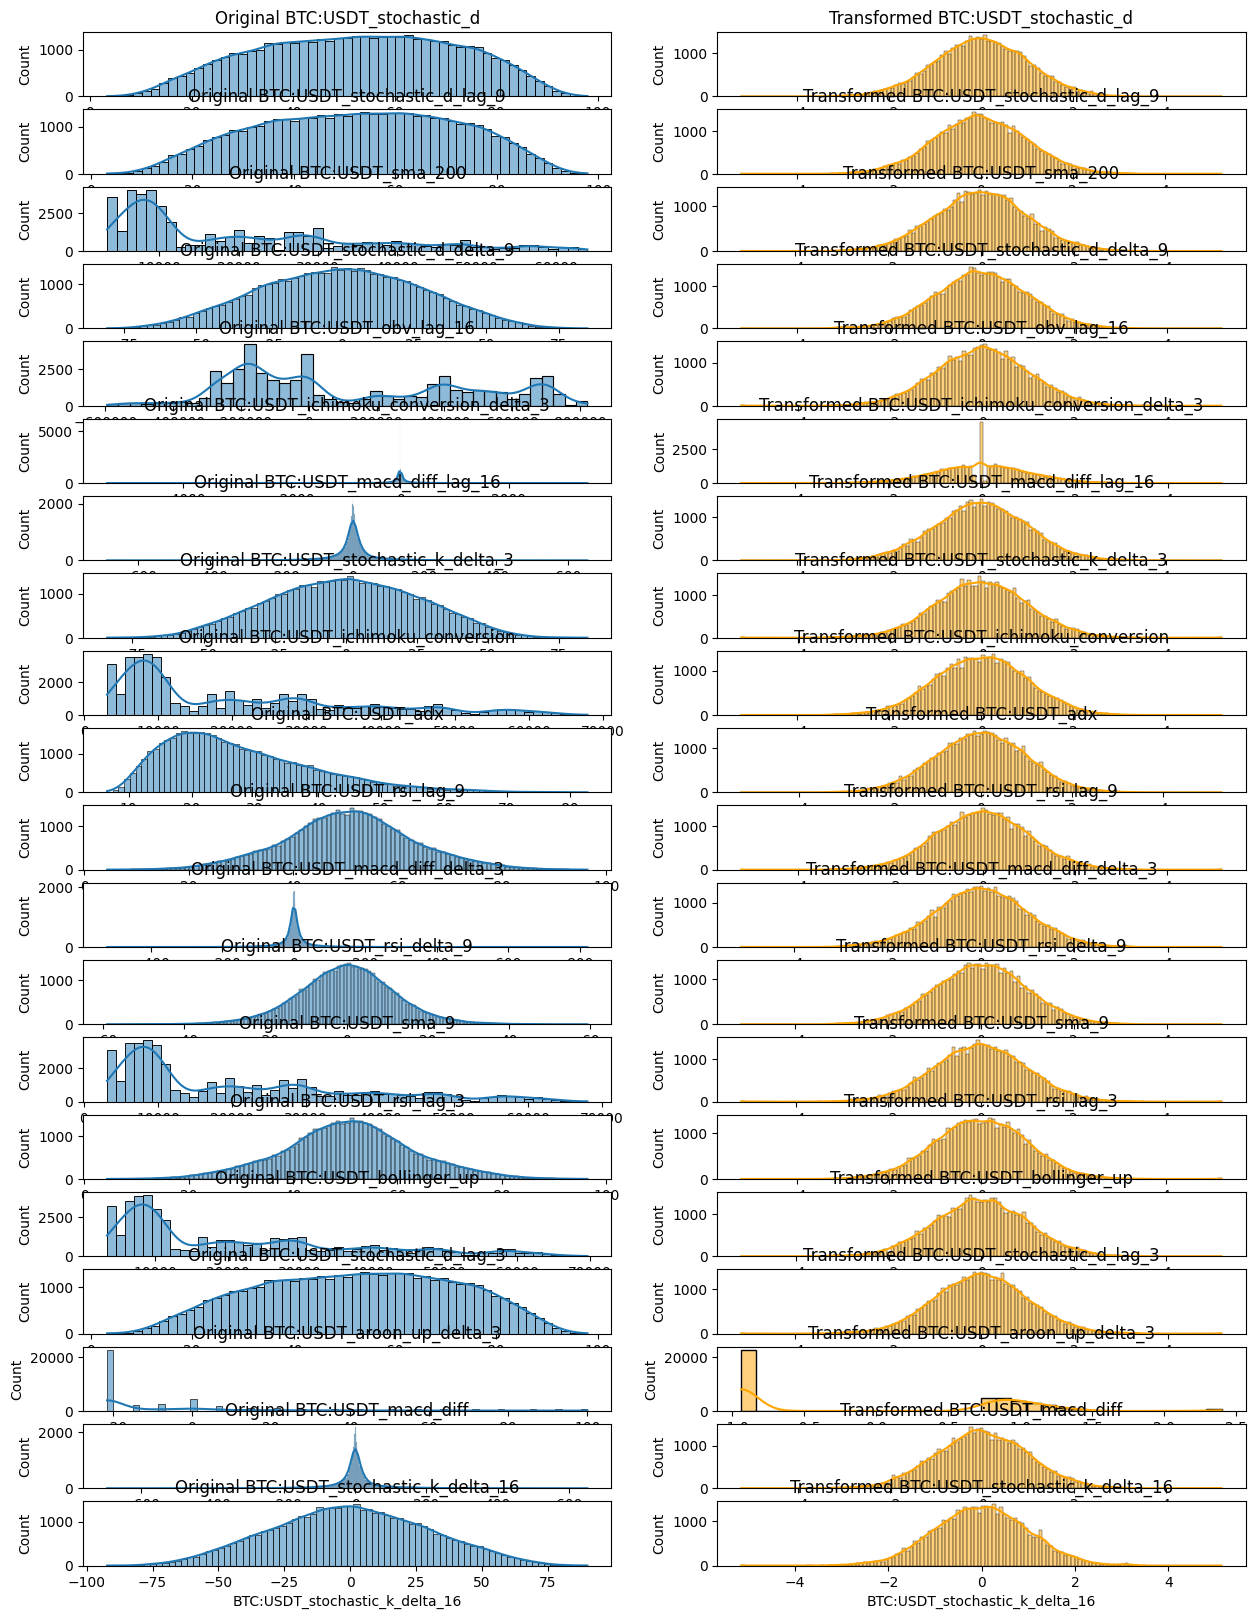

In [42]:
# Apply Quantile Transformer
transform_pipe = Pipeline(
    [
        (
            "Normilizer",
            QuantileTransformer(output_distribution="normal", random_state=99),
        ),
        ("Scaler", StandardScaler()),
    ]
)
X_train_transformed = transform_pipe.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)

# Select 20 random columns (same as before)
num_cols = min(len(X_train.columns), 20)
random_columns = np.random.choice(X_train.columns, num_cols, replace=False)

# Set up the matplotlib figure (2 rows for each column: before and after)
plt.figure(figsize=(15, 2 * 20))  # Adjust the size as needed

# Plot each histogram before and after transformation
for i, col in enumerate(random_columns):
    # Original Data
    plt.subplot(2 * num_cols, 2, 2 * i + 1)  # 2*num_cols rows, 2 columns per row
    sns.histplot(X_train[col], kde=True)
    plt.title(f"Original {col}")
    # plt.tight_layout()

    # Transformed Data
    plt.subplot(2 * num_cols, 2, 2 * i + 2)
    sns.histplot(X_train_transformed[col], kde=True, color="orange")
    plt.title(f"Transformed {col}")
    # plt.tight_layout()

plt.show()

# Test of feature selection

In [19]:
# Example using RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
sfm = SelectFromModel(model)

# Assume X_train and y_train are your training data and labels
sfm.fit(X_train, y_train)

# To see the features selected
selected_features = sfm.get_support()
print("Selected features:", selected_features)

# To get the names of the selected features if you have a DataFrame
selected_feature_names = X_train.columns[selected_features]
print("Selected feature names:", selected_feature_names)

Selected features: [ True  True  True  True  True  True  True  True  True  True  True False
 False False False False False  True False False False False False False
 False False False False False False False False  True  True  True False
 False False False False False False  True False False False False False
  True  True  True False False False False False False  True  True False
 False False False]
Selected feature names: Index(['BTC:USDT_sma_9', 'BTC:USDT_sma_20', 'BTC:USDT_sma_50',
       'BTC:USDT_sma_200', 'BTC:USDT_rsi', 'BTC:USDT_bollinger_up',
       'BTC:USDT_bollinger_down', 'BTC:USDT_adx', 'BTC:USDT_macd_diff',
       'BTC:USDT_obv', 'BTC:USDT_ichimoku_conversion', 'BTC:USDT_obv_lag_3',
       'BTC:USDT_macd_diff_lag_9', 'BTC:USDT_obv_lag_9',
       'BTC:USDT_ichimoku_conversion_lag_9',
       'BTC:USDT_ichimoku_conversion_delta_9', 'BTC:USDT_macd_diff_lag_16',
       'BTC:USDT_obv_lag_16', 'BTC:USDT_ichimoku_conversion_lag_16',
       'BTC:USDT_obv_delta_16', 'BTC:USDT_ich

# Pipeline

In [37]:
# Creating the pipeline
random_forest_pipeline = Pipeline(
    [
        (
            "Normilizer",
            QuantileTransformer(output_distribution="normal", random_state=99),
        ),
        ("Scaler", StandardScaler()),
        (
            "FeatureSelection",
            SelectFromModel(RandomForestRegressor(random_state=99, n_jobs=-1)),
        ),
        ("model", RandomForestRegressor(random_state=99, n_jobs=-1)),
    ]
)

# Grid Search


In [ ]:
param_grid = {
    "model__n_estimators": [100, 200, 400],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_split": [2, 10],
    "model__min_samples_leaf": [1, 4],
    "model__max_features": ["sqrt", "log2"],
}

grid_search = GridSearchCV(
    random_forest_pipeline, param_grid, cv=5, n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_